In [1]:
#!pip install celluloid

In [2]:
import numpy as np
import pandas
from matplotlib import pyplot as plt
from celluloid import Camera
from IPython.display import clear_output
import json

# Prepare data

In [3]:
cities = pandas.read_csv('city.csv', usecols = ['Регион', 'Город', 'Широта', 'Долгота', 'Население'])
cities['Город'] = np.where(cities['Город'] != cities['Город'], cities['Регион'], cities['Город'])
cities['Население'] = cities['Население'].apply(lambda x : int(x) if x.isdigit() else 0)
cities = cities.sort_values(by = ['Население'], ascending=False)
cities = cities.drop(columns = ['Регион', 'Население']).values[:30]

# Helper functions

In [4]:
def geo_dist(lat_1, lng_1, lat_2, lng_2): 
    d_lat = (lat_2 - lat_1) * np.pi / 180
    d_lng = (lng_2 - lng_1) * np.pi / 180
    lat_1 = lat_1 * np.pi / 180
    lat_2 = lat_2 * np.pi / 180
    temp = np.sin(d_lat / 2) ** 2 + np.cos(lat_1) * np.cos(lat_2) * np.sin(d_lng / 2) ** 2
    return 6371.0 * (2 * np.arctan2(np.sqrt(temp), np.sqrt(1 - temp)))

In [5]:
def is_accept(old_dist, new_dist, T):
    ar = np.exp(-new_dist / T) / np.exp(-old_dist / T)
    return np.random.uniform() <= ar

In [6]:
def path_dist(cities):
    dist = geo_dist(cities[0][1], cities[0][2], cities[-1][1], cities[-1][2])
    for (_, lat1, lng1), (_, lat2, lng2) in zip(cities, cities[1:]):
        dist += geo_dist(lat1, lng1, lat2, lng2)
    return dist

In [7]:
def propose_path(cities):
    fst = np.random.randint(0, len(cities))
    snd = np.random.randint(0, len(cities))
    tmp = cities[fst].copy()
    cities[fst] = cities[snd]
    cities[snd] = tmp

In [8]:
def draw_path(cities):
    plt.scatter([x[1] for x in cities], [x[2] for x in cities], color='b')
    plt.plot([x[1] for x in cities] + [cities[0][1]], [x[2] for x in cities] + [cities[0][2]], color='b')
    for name, lat, lng in cities:
        plt.annotate(name, (lat, lng))

In [9]:
def save_animation(cities_history, file_name):
    camera = Camera(plt.figure())
    for cities_prev, cities in zip(cities_history, cities_history[1:]):
        if ((cities_prev == cities).all()):
            continue
        draw_path(cities)
        plt.title(f"Distance = {path_dist(cities)}")
        camera.snap()
    camera.animate().save(file_name, 'pillow', fps=15)

# Simulated annealing optimizer

In [10]:
def find_optimal_path(cities, T = 1000, min_T = 20, annealing_rate = 0.95, 
                      annealing_iterations = 10, _save_animation = False):
    plt.rcParams["figure.figsize"] = (20,6)
    np.random.shuffle(cities)
    dists = []
    citites_history = [] 
    it = 0
    
    while (T > min_T):
        old_cities = cities.copy()
        old_dist = path_dist(cities)
        propose_path(cities)
        dist = path_dist(cities)
        
        if not is_accept(old_dist, dist, T):
            cities = old_cities
            dist = old_dist
                
        dists.append(dist)
        citites_history.append(cities.copy())
        
        it += 1
        if it % annealing_iterations == 0:
            T *= annealing_rate
        
        if it % 50 == 0:
            # redraw plot each 50 iterations
            clear_output(wait=True)
            plt.subplot(1, 2, 1)
            plt.plot(np.arange(len(dists)), dists, color='b')
            plt.xlabel('iteration')
            plt.ylabel('dist')
            plt.title(f'T = {T}, dist = {dist}')
            plt.subplot(1, 2, 2)
            draw_path(cities)
            plt.show()
    
    if _save_animation:
        save_animation(citites_history, f'optimization-{annealing_rate}.gif')
    
    return cities

# Optimize and evaluate

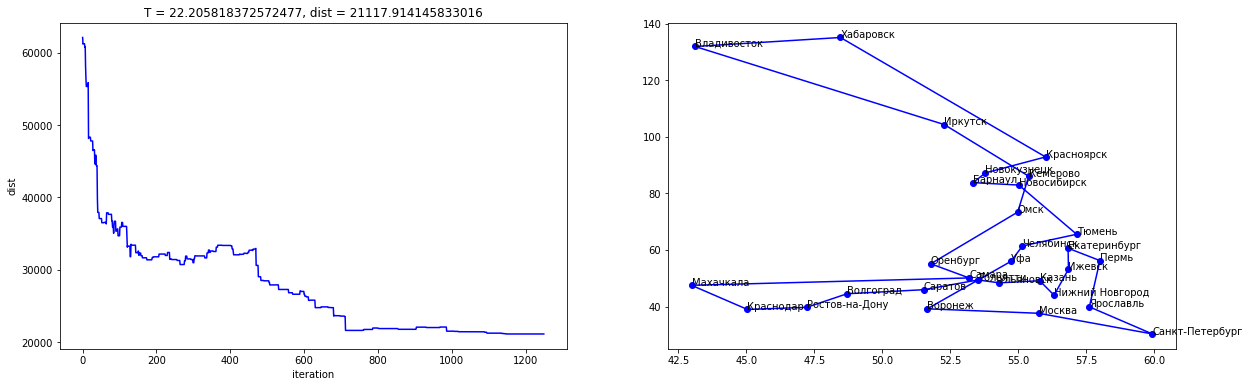

Annealing rate: 0.97
Optimal distance: 21117.914145833016
Wall time: 24 s


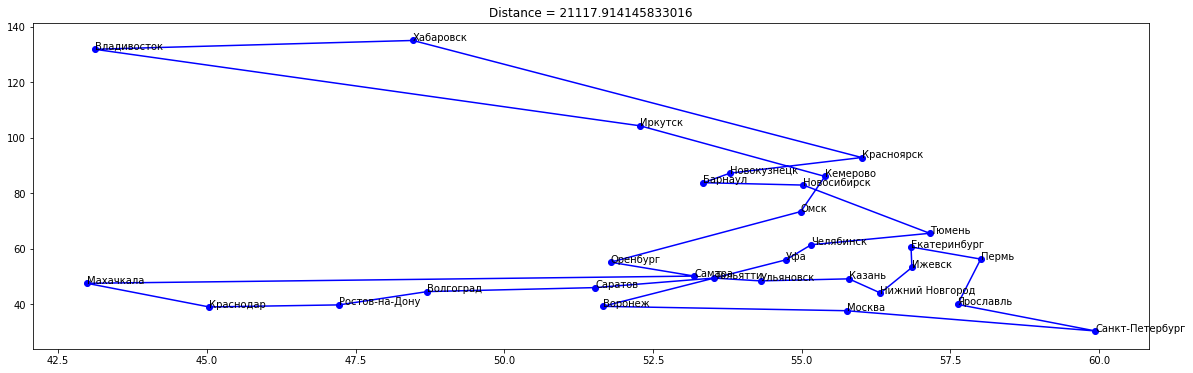

In [11]:
%%time
annealing_rate = 0.97
cities = find_optimal_path(cities, annealing_rate=annealing_rate, _save_animation=True)
print(f'Annealing rate: {annealing_rate}\nOptimal distance: {path_dist(cities)}')

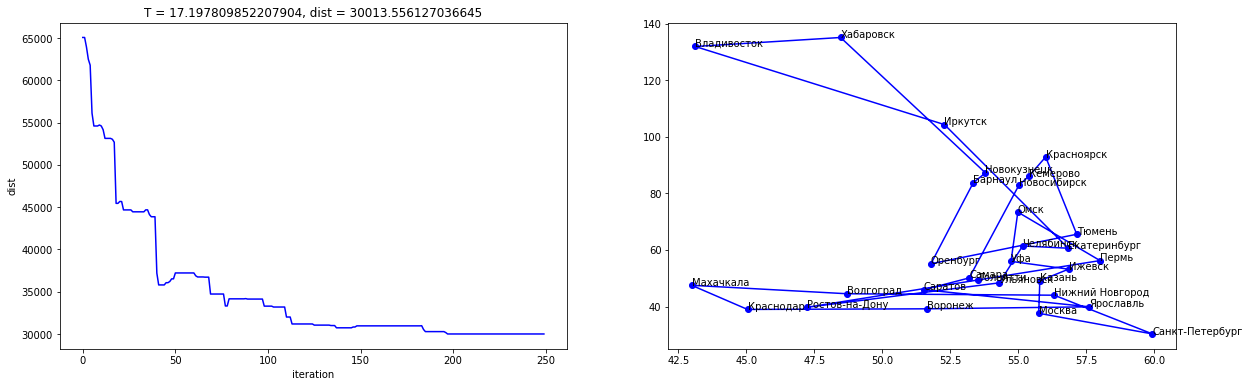

Annealing rate: 0.85
Optimal distance: 30013.556127036645
Wall time: 6.89 s


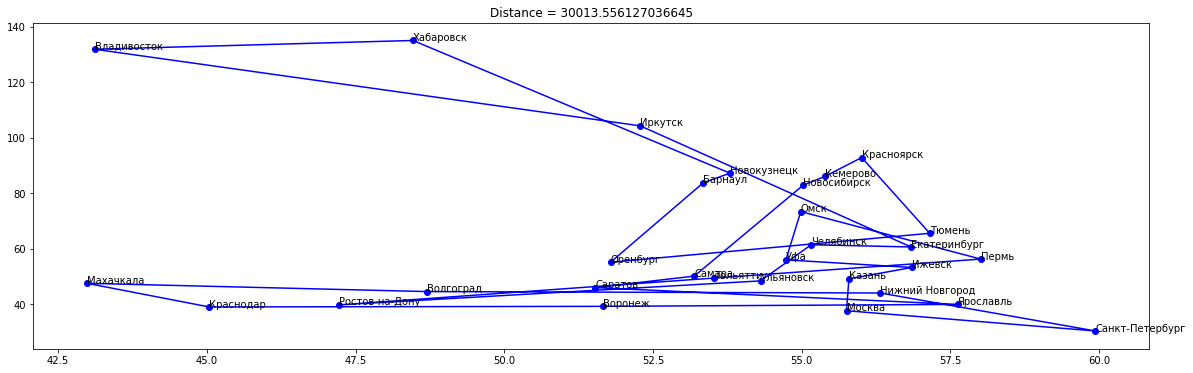

In [12]:
%%time
annealing_rate = 0.85
cities = find_optimal_path(cities, annealing_rate=annealing_rate, _save_animation=True)
print(f'Annealing rate: {annealing_rate}\nOptimal distance: {path_dist(cities)}')

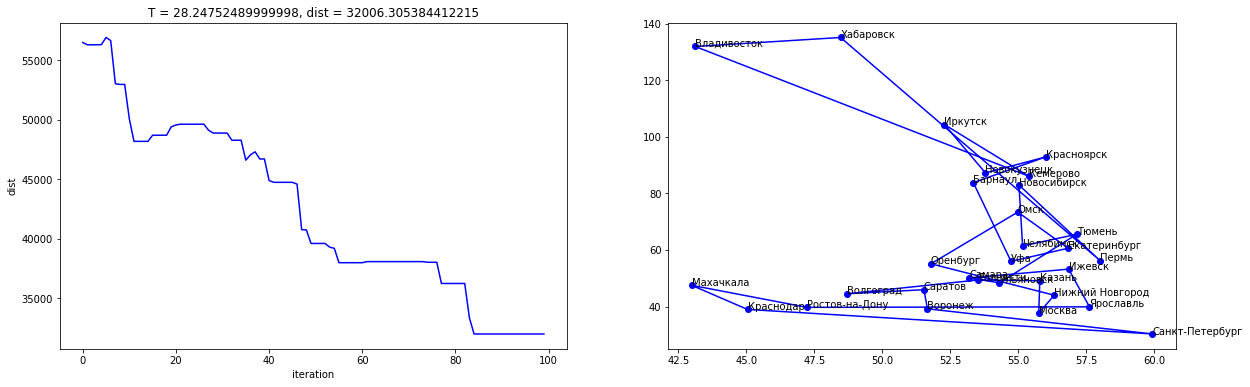

Annealing rate: 0.7
Optimal distance: 32006.305384412215
Wall time: 4.71 s


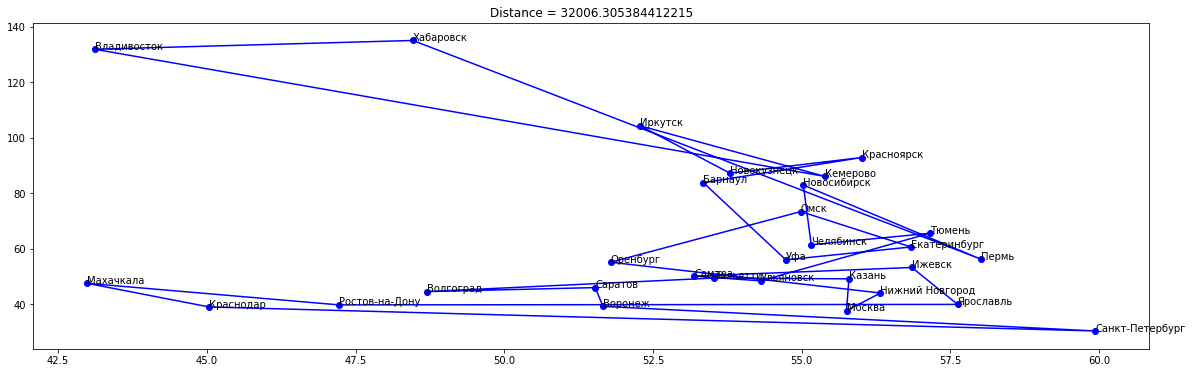

In [13]:
%%time
annealing_rate = 0.7
cities = find_optimal_path(cities, annealing_rate=annealing_rate, _save_animation=True)
print(f'Annealing rate: {annealing_rate}\nOptimal distance: {path_dist(cities)}')